# Explore

- spark doesn't do visualization
- several strategies:
    - aggregation / analysis in spark
    - samples: random or by subgroup
    - aggregation in spark, viz in pandas
- big data -> smaller, more managable subset -> laptop (pandas) -> viz (matplotlib, seaborn)

In [1]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

## All in Spark

How many opened and closed cases are there?

In [2]:
df.groupby("case_status").count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



What's the average amount of time a case is open?

In [3]:
df.groupby("case_status").agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108263294778737|
+-----------+------------------+



How many requests are there by department?

In [4]:
the_pandas_dataframe_we_know_and_love = df.groupBy("department").count().toPandas()
the_pandas_dataframe_we_know_and_love

,department,count
0,Solid Waste,279270
1,Animal Care Services,116915
2,Trans & Cap Improvements,96193
3,Parks & Recreation,19907
4,Customer Service,2849
5,Metro Health,5163
6,City Council,33
7,DSD/Code Enforcement,321374


In [5]:
type(the_pandas_dataframe_we_know_and_love)

pandas.core.frame.DataFrame

Text(0.5, 1.0, 'How many cases does each department handle?')

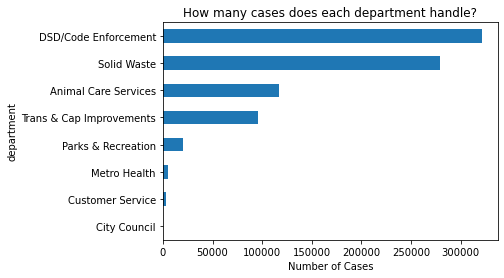

In [6]:
(
    df.groupBy("department")
    .count() # aggregate with spark
    .toPandas() # converts to a pandas dataframe
    .set_index('department')
    ['count'] # a single pandas series
    .sort_values()
    .plot.barh() # pandas built-in plotting
)
plt.xlabel('Number of Cases')
plt.title('How many cases does each department handle?')

## Aggregate With Spark

What does the case lifetime look like for each department?

Text(0.5, 0, 'Number of Cases')

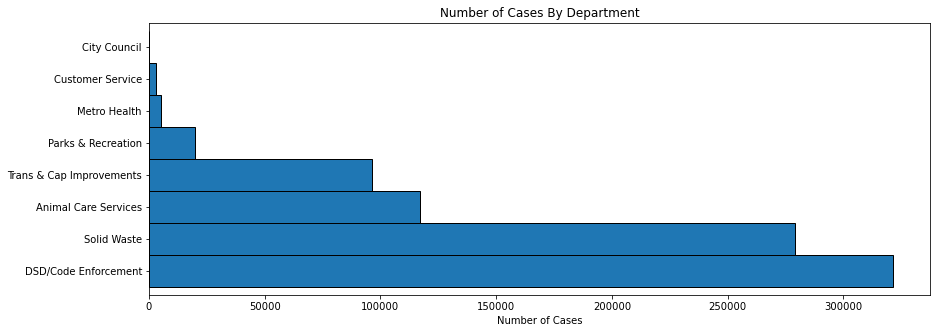

In [7]:
# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

Text(0.5, 1.0, 'Case Lifetime By Department')

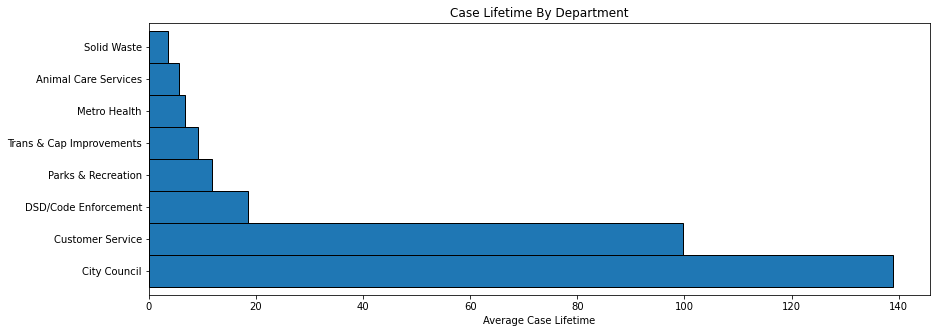

In [8]:
# first aggregate with spark
(
    df.groupBy("department")
    .agg(mean("case_lifetime").alias("avg_case_lifetime"))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("department")
    .avg_case_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("")
plt.title("Case Lifetime By Department")

Average case lifetime by department for both open and closed cases:

Text(0.5, 0, 'Average case lifetime')

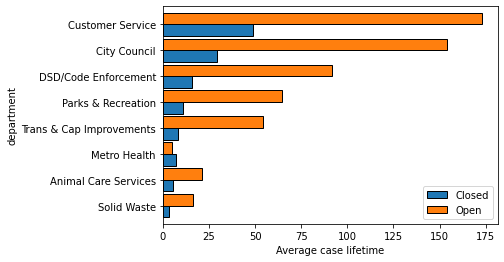

In [9]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .toPandas()
    .set_index('department')
    .plot.barh(ec='black', width=.9)
)
plt.xlabel('Average case lifetime')

## Sample

In [10]:
sample = df.sample(fraction=0.01, seed=13).toPandas()
print("shape:", sample.shape)
sample.head()

shape: (8522, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,SAN FERNANDO and SAN HORACIO S,005,-0.394762,,219,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 SURFRIDER, San Antonio, 78242",004,-142.713297,78242,219,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True


<AxesSubplot:ylabel='Frequency'>

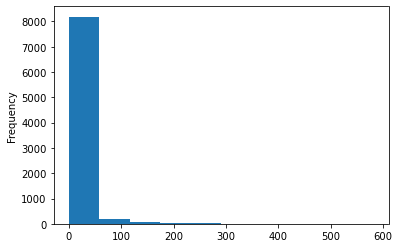

In [11]:
sample.case_lifetime.plot.hist()

In [12]:
pd.cut(sample.case_lifetime, 4).value_counts().sort_index()

(-0.581, 145.25]    8414
(145.25, 290.5]       84
(290.5, 435.75]       15
(435.75, 581.0]        9
Name: case_lifetime, dtype: int64

[0, 1)        2539
[1, 2)        1649
[2, 5)        1453
[5, 15)       1449
[15, 1000)    1432
Name: case_lifetime, dtype: int64


Text(0.5, 1.0, 'Overall Case Lifetime')

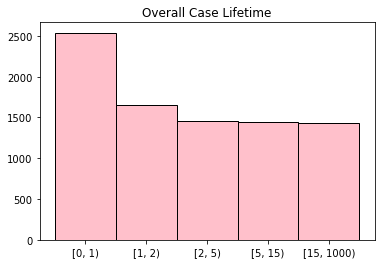

In [13]:
# In the call to `pd.cut`, we add right=False so that the behavior of pd.cut
# aligns with the behavior of np.histogram, which is what matplotlib uses when
# constructing a histogram.

# custom bins of varying widths
bins = [0, 1, 2, 5, 15, 1000]

print(
    pd.cut(sample.case_lifetime, bins, right=False).value_counts().sort_index()
)

pd.cut(
    sample.case_lifetime, bins, right=False
).value_counts().sort_index().plot.bar(
    width=1, edgecolor="black", color="pink"
)
plt.xticks(rotation=0)
plt.title("Overall Case Lifetime")

In [14]:
closed_cases = sample.query("case_closed")
open_cases = sample.query("not case_closed")

Text(0.5, 0.98, 'Distribution of Case Lifetime')

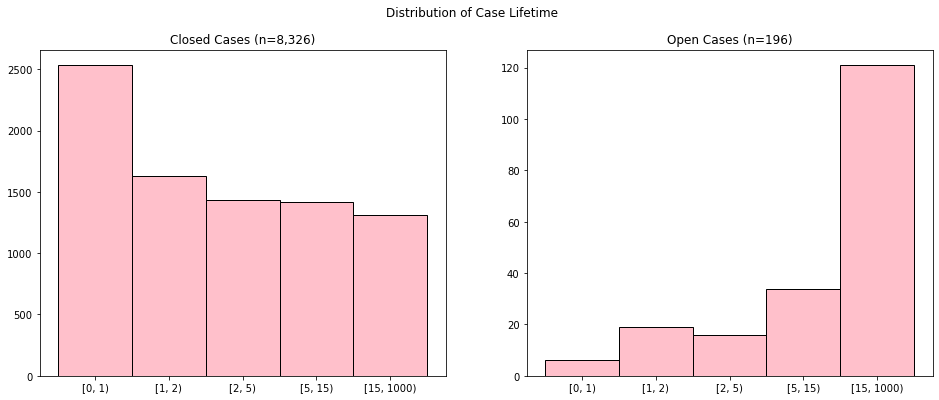

In [15]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
(
    pd.cut(closed_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Closed Cases (n={:,})".format(closed_cases.shape[0]))
plt.xticks(rotation=0)

plt.subplot(122)
(
    pd.cut(open_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Open Cases (n={:,})".format(open_cases.shape[0]))
plt.xticks(rotation=0)

plt.suptitle("Distribution of Case Lifetime")

## Aggregating

In [16]:
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [17]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'
cases_opened_by_day

case_opened_date
2017-01-01     155
2017-01-02    1397
2017-01-03    1760
2017-01-04    1613
2017-01-05    1791
              ... 
2018-08-04     665
2018-08-05     319
2018-08-06    2071
2018-08-07    2405
2018-08-08     604
Name: cases_opened, Length: 585, dtype: int64

In [18]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [19]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173
...,...,...
2018-08-04,665,730
2018-08-05,319,197
2018-08-06,2071,1713
2018-08-07,2405,2096


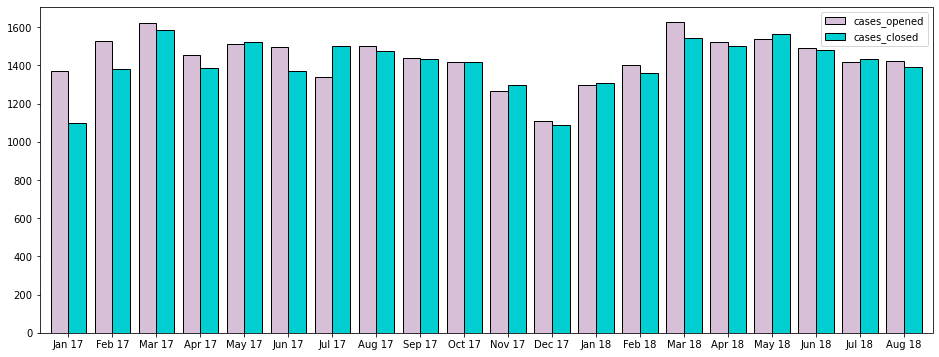

In [20]:
ts.resample("M").mean().plot.bar(
    figsize=(16, 6), width=0.8, ec="black", color=["thistle", "darkturquoise"]
)

# pretty x-axis labels
ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%b %y")
plt.xticks(ticks, labels, rotation=0)
None

<AxesSubplot:xlabel='weekday'>

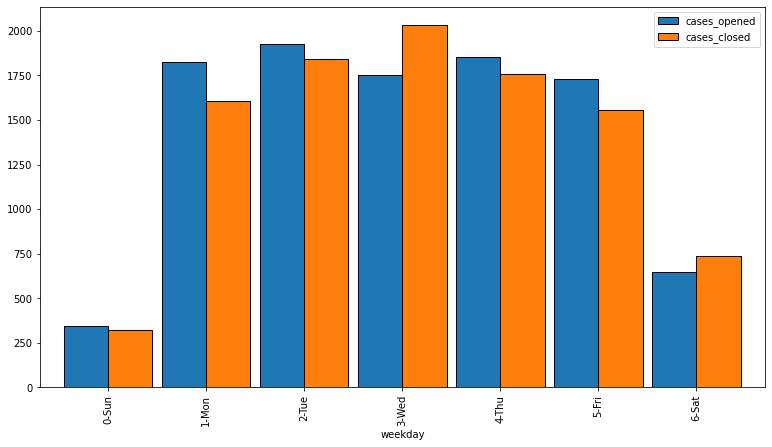

In [21]:
ts['weekday'] = ts.index.strftime('%w-%a')
ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)